# remove_pli testing

This notebook follows the examples laid out in [test_removePLI.m](https://github.com/mrezak/removePLI/blob/master/test_removePLI.m), wherein four different example of biosignal datasets with power line noise are "cleaned" using the removePLI algorithm. 

In [1]:
%matplotlib notebook
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

import seaborn as sns
plt.style.use('seaborn-ticks')

from remove_pli import remove_pli

# Test data

The test data comprises of the original data \*.mat files from [removePLI](https://github.com/mrezak/removePLI) as well as corresponding datasets that were processed using the MATLAB implementation. These are packaged in the test_data.tar archive, which can be downloaded [here](https://github.com/alafuzof/remove_pli/releases/download/test_data/test_data.tar).

In [3]:
import urllib.request
import tarfile 

test_data_url = 'https://github.com/alafuzof/remove_pli/releases/download/test_data/test_data.tar'
test_data_file, headers = urllib.request.urlretrieve(test_data_url)
test_data = tarfile.TarFile(test_data_file, 'r')

# Plotting

The following function plots the original signal power spectrum (BEFORE) and the Python and MATLAB cleaned (AFTER) spectra. The final subplot shows the difference between the MATLAB and Python cleaned spectra. 

In [4]:
def plot_psd(freqs, original_pxx, python_clean_pxx, matlab_clean_pxx, xlim, ylim, title):
    fig = plt.figure(figsize=(10,10))
    fig.set_tight_layout(True)

    ax = fig.add_subplot(311)
    ax.plot(freqs, 10*np.log10(original_pxx))
    ax.set_xlim(xlim)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylim(ylim)
    ax.set_ylabel('Power/frequency (db/Hz)')
    ax.set_title('{} data, PSD (BEFORE)'.format(title))    
    
    ax = fig.add_subplot(312)
    ax.plot(freqs, 10*np.log10(python_clean_pxx), label='Python')
    ax.plot(freqs, 10*np.log10(matlab_clean_pxx), label='MATLAB')
    ax.set_xlim(xlim)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylim(ylim)
    ax.set_ylabel('Power/frequency (db/Hz)')
    ax.legend()
    ax.set_title('{} data, PSD (AFTER)'.format(title))
    
    ax = fig.add_subplot(313)
    ax.plot(freqs, 10*np.log10(python_clean_pxx)-10*np.log10(matlab_clean_pxx), label='Difference')
    ax.set_xlim(xlim)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylim((-0.1, 0.1))
    ax.set_ylabel('Power/frequency (db/Hz)')
    ax.set_title('{} data, PSD (AFTER: MATLAB vs Python)'.format(title))
    
    sns.despine()
    
    return fig

# Intracortical data

The first example is of 30 seconds of intracortical data sampled at 40000 Hz. The data exhibits a fundamental at ~60 Hz and 3-4 harmonics (the third harmonic is not visible). This is the only dataset that shows differences between the MATLAB and Python implementations, but even these differences are miniscule (< 0.05 dB). This difference may come from some small variations in how filter design is implemented in Scipy and MATLAB.

<IPython.core.display.Javascript object>


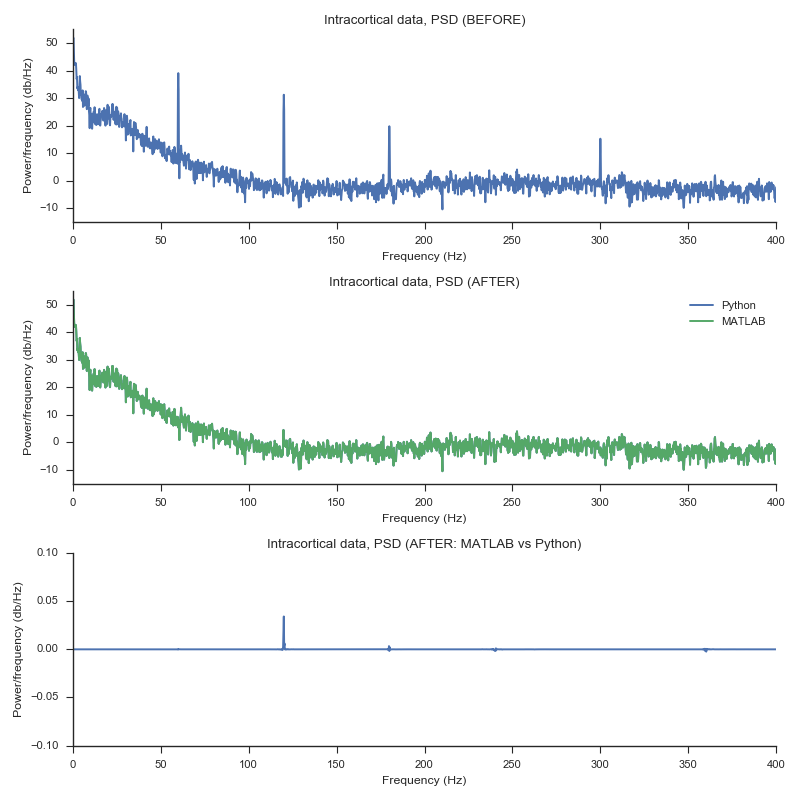

In [5]:
data = np.squeeze(scipy.io.loadmat(test_data.extractfile('intracortical.mat'))['data'])

fs = 40000              # Sample rate (Hz)
orig_data = (data/2**15)*10**4  # Scaling to mV

M = 6 # number of harmonics to remove
B = [50, 0.2, 1.0]
P = [0.1, 4.0, 1.0]
W = 2.0

clean_data = remove_pli(orig_data, fs, M, B, P, W)
matlab_clean_data = np.squeeze(scipy.io.loadmat(test_data.extractfile('intracortical_clean.mat'))['s'])

original_pxx, freqs =  plt.mlab.psd(orig_data[fs:], Fs=fs, NFFT=fs*5)
python_clean_pxx, freqs = plt.mlab.psd(clean_data[fs:], Fs=fs, NFFT=fs*5)
matlab_clean_pxx, freqs = plt.mlab.psd(matlab_clean_data[fs:], Fs=fs, NFFT=fs*5)

fig = plot_psd(freqs, original_pxx, python_clean_pxx, matlab_clean_pxx, 
               xlim=[0,400], 
               ylim=[-15, 55], 
               title='Intracortical')

# ECoG

The ECoG dataset is a 60 second recording sampled at 1000 Hz. The dataset shows power line noise at a fundamental of ~50 Hz and harmonics up to 450 Hz. The fundamental and the first six harmonics are removed. There is virtually no difference between the Python and MATLAB implementations.

<IPython.core.display.Javascript object>


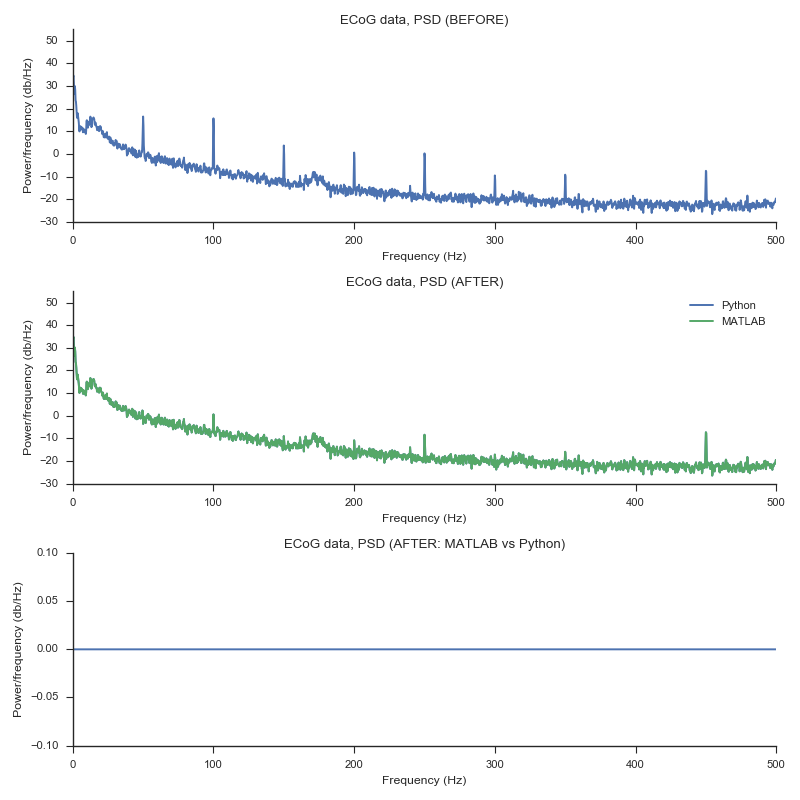

In [6]:
data = np.squeeze(scipy.io.loadmat(test_data.extractfile('ECoG.mat'))['data'])

fs = 1000 # Sample rate (Hz)
orig_data = data # Scaling to mV

M = 7 # number of harmonics to remove
B = [50, 0.2, 1]
P = [0.1, 4, 1]
W = 1

clean_data = remove_pli(orig_data, fs, M, B, P, W)
matlab_clean_data = np.squeeze(scipy.io.loadmat(test_data.extractfile('ECoG_clean.mat'))['s'])

original_pxx, freqs = plt.mlab.psd(orig_data[fs:], Fs=fs, NFFT=fs*4)
python_clean_pxx, freqs = plt.mlab.psd(clean_data[fs:], Fs=fs, NFFT=fs*4)
matlab_clean_pxx, freqs = plt.mlab.psd(matlab_clean_data[fs:], Fs=fs, NFFT=fs*4)

fig = plot_psd(freqs, original_pxx, python_clean_pxx, matlab_clean_pxx, 
               xlim=[0, 500], 
               ylim=[-30, 55], 
               title='ECoG')

# EEG

The third dataset is a 60 second segment of EEG data sampled at 160 Hz. The power line fundamental at ~60 Hz is removed. Again there is virtually no difference between the implementations.

<IPython.core.display.Javascript object>


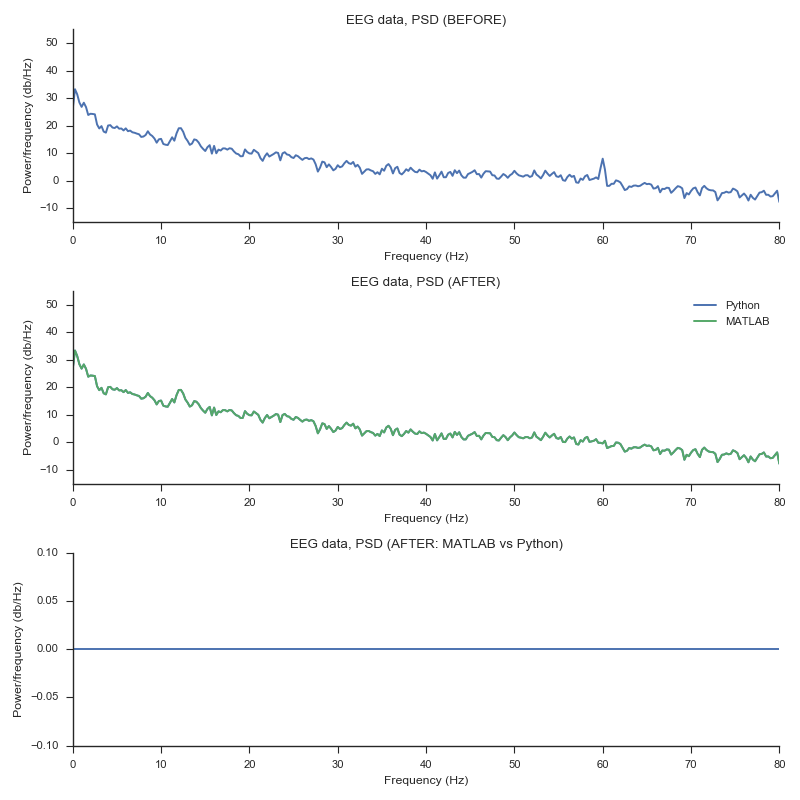

In [7]:
data = np.squeeze(scipy.io.loadmat(test_data.extractfile('EEG.mat'))['data'])

fs = 160 # Sample rate (Hz)
orig_data = data # Scaling to mV

M = 1 # number of harmonics to remove
B = [50, 0.05, 5]
P = [0.001, 2, 5]
W = 3

clean_data = remove_pli(orig_data, fs, M, B, P, W)
matlab_clean_data = np.squeeze(scipy.io.loadmat(test_data.extractfile('EEG_clean.mat'))['s'])

original_pxx, freqs = plt.mlab.psd(orig_data[fs:], Fs=fs, NFFT=fs*4)
python_clean_pxx, freqs = plt.mlab.psd(clean_data[fs:], Fs=fs, NFFT=fs*4)
matlab_clean_pxx, freqs = plt.mlab.psd(matlab_clean_data[fs:], Fs=fs, NFFT=fs*4)

fig = plot_psd(freqs, original_pxx, python_clean_pxx, matlab_clean_pxx, 
               xlim=[0, 80], 
               ylim=[-15, 55], 
               title='EEG')

# ECG

The final example is 60 seconds of ECG data sampled at 250 Hz. The fundamental at ~60 Hz as well as two harmonics are removed. Note that the second harmonic (~180 Hz) is above the Nyquist frequency! This dataset once again shows that there is no difference in the quality of the results between MATLAB and Python implementations.

<IPython.core.display.Javascript object>


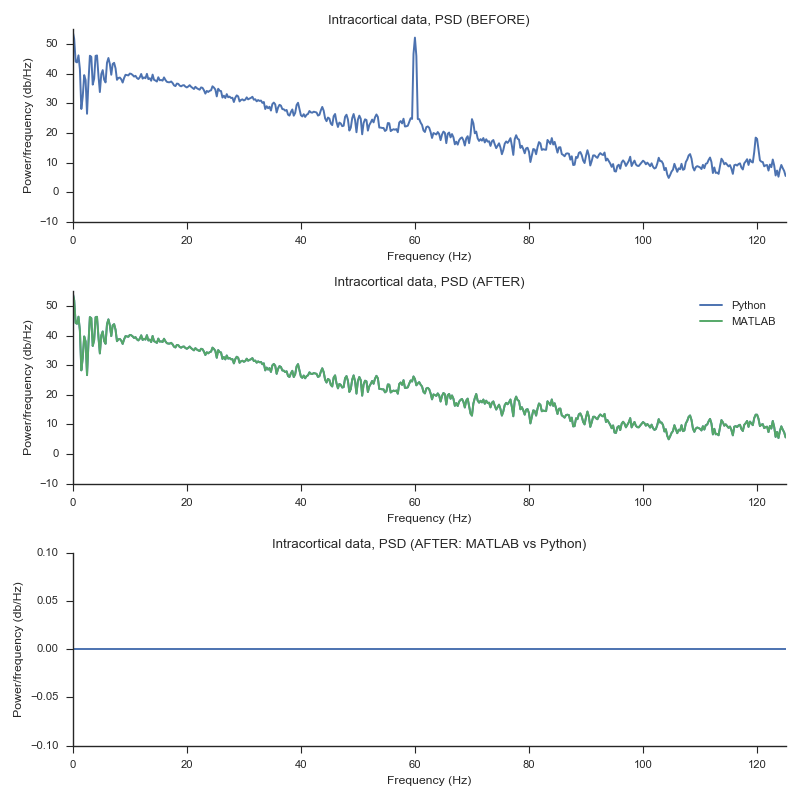

In [8]:
data = np.squeeze(scipy.io.loadmat(test_data.extractfile('ECG.mat'))['data'])

fs = 250 # Sample rate (Hz)
orig_data = data # Scaling to mV

M = 3 # number of harmonics to remove
B = [50, 0.05, 1]
P = [0.01, 2, 1]
W = 1.8

clean_data = remove_pli(orig_data, fs, M, B, P, W)
matlab_clean_data = np.squeeze(scipy.io.loadmat(test_data.extractfile('ECG_clean.mat'))['s'])

original_pxx, freqs = plt.mlab.psd(orig_data[fs:], Fs=fs, NFFT=fs*4)
python_clean_pxx, freqs = plt.mlab.psd(clean_data[fs:], Fs=fs, NFFT=fs*4)
matlab_clean_pxx, freqs = plt.mlab.psd(matlab_clean_data[fs:], Fs=fs, NFFT=fs*4)

fig = plot_psd(freqs, original_pxx, python_clean_pxx, matlab_clean_pxx, 
               xlim=[0, 125], 
               ylim=[-10, 55], 
               title='Intracortical')